# Simple Stock Prediction

Goal: Predict Apple stock price using a Recurrent Neural Network (RNN)

Dataset from [DataMarket](https://datamarket.com/data/list/?q=provider%3Atsdl)

Based on [RNN project: Time Series Prediction](https://github.com/udacity/aind2-rnn) project of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper

%load_ext autoreload
%autoreload 2

## Load the data

In [24]:
dataset = np.loadtxt('data/apple_prices.csv')
print("Days: {}".format(len(dataset)))

Days: 138


## Visualize the data


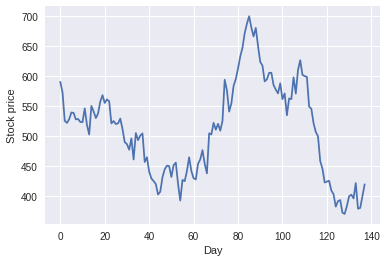

In [25]:
#print(dataset)
plt.plot(dataset)
plt.xlabel('Day')
plt.ylabel('Stock price')

## Process the Data

In [26]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
dataset = scaler.fit_transform(dataset.reshape(-1,1))

dataset.reshape(-1)

array([ 0.33600865,  0.23058249, -0.05797255, -0.07888723, -0.04167795,
        0.02647845,  0.0215537 , -0.04362396, -0.03961061, -0.06964596,
       -0.07128729,  0.06763947, -0.09858659, -0.19616956,  0.09238492,
        0.03717885, -0.03018676,  0.01565595,  0.13731586,  0.20139842,
        0.12248076,  0.1582309 ,  0.1405989 , -0.08423762, -0.06010039,
       -0.09050015, -0.08375149, -0.03547666, -0.14047718, -0.27387135,
       -0.29375309, -0.35035725, -0.23575011, -0.44915666, -0.18163838,
       -0.25399015, -0.20747837, -0.18565155, -0.47432738, -0.42672144,
       -0.57197158, -0.64091822, -0.66797389, -0.69776581, -0.80367848,
       -0.77504195, -0.62887985, -0.54807742, -0.5115977 , -0.5166438 ,
       -0.62602226, -0.50685535, -0.48131966, -0.69569846, -0.86478211,
       -0.65587485, -0.66894689, -0.5652836 , -0.42672144, -0.56801947,
       -0.63915498, -0.65101096, -0.49262809, -0.44854844, -0.35491721,
       -0.4922635 , -0.59002904, -0.18431376, -0.19574392, -0.07

## Split into sequences

Run a sliding window along the input series and creates associated input/output pairs

In [27]:
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # fill input/output lists from the given sequence
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])   # size: sliding window 
        y.append(series[i + window_size])       # size: scalar    
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [28]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

## Split into training and testing sets

Here we are not splitting the dataset randomly as the input/output pairs are related temporally

In [29]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Recurrent Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 146.0
Trainable params: 146
Non-trainable params: 0.0
_________________________________________________________________
Training ...
Epoch 00682: early stopping


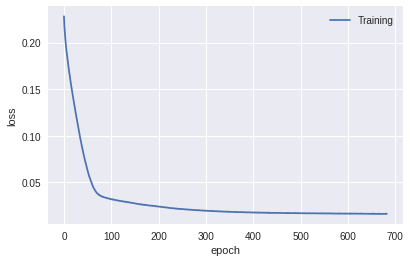

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(9)

model = Sequential()  # create Keras sequential model
model.add(LSTM(5, input_shape = (window_size,1)))  # LSTM layer with 5 units
model.add(Dense(1, activation=None))   # linear fully connected layer
model.summary()  # show model

# build model 
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)]


# train the model
print("Training ...")
history = model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0, callbacks=callbacks)

helper.plot_training(history)

## Evaluate the model

In [43]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [44]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.0160808544606
testing error = 0.0177155712316


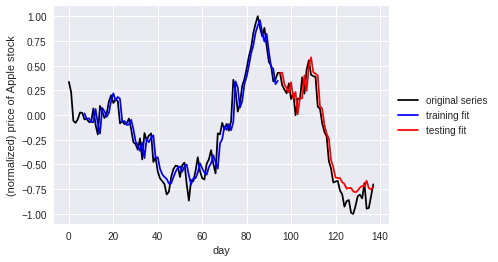

In [11]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()